# Regularization and Tree-Based Models

In this notebook, we'll try out some additional models on the heart disease dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from cm import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
heart = pd.read_csv('../data/Heart.csv')

Recall the variable descriptions:

|Variable | Description |
|---|---|
| Age | age in years |
| Sex | Sex (0 = female; 1 = male;) |
| ChestPain | chest pain type |
| RestBP | resting blood pressure (in mm Hg on admission to the hospital) |
| Chol | serum cholestoral in mg/dl |
| Fbs | fasting blood sugar > 120 mg/dl (1 = true; 0 = false) |
| RestECG | resting electrocardiographic results (0: normal; 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV); 2: showing probable or definite left ventricular hypertrophy by Estes' criteria) |
| MaxHR | maximum heart rate achieved |
| ExAng | exercise induced angina (0 = no, 1 = yes;) |
| Oldpeak | ST depression induced by exercise relative to rest |
| Slope | the slope of the peak exercise ST segment (1: upsloping; 2: flat; 3: downsloping) |
| Ca | number of major vessels (0-3) colored by flourosopy |
| Thal | Thallium stress test  | 
| AHD | Presence of heart disease (target) |

In [3]:
categorical_variables = ['ChestPain', 'RestECG', 'Slope', 'Thal']
heart = pd.get_dummies(heart, columns = categorical_variables)

### Logistic Regression from Last Time

In [4]:
X = heart.drop(columns = ['AHD'])
y = heart['AHD']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,     # Keep the same proportions of the target in the training and test data
                                                    test_size = 0.25,
                                                    random_state = 321)

In [6]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [7]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]

In [8]:
roc_auc_score(y_test, y_pred_prob)

0.9542857142857142

In [9]:
y_pred = logreg.predict(X_test)

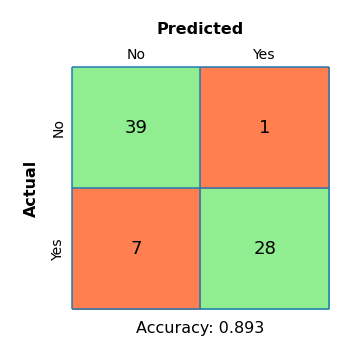

In [10]:
plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')

## Tree-Based Models

In [11]:
from sklearn.tree import DecisionTreeClassifier

A decision tree model is fit in much the same way as a logistic regression model.

In [12]:
tree = DecisionTreeClassifier(random_state = 321).fit(X_train, y_train)

First, let's see how it does on the training data.

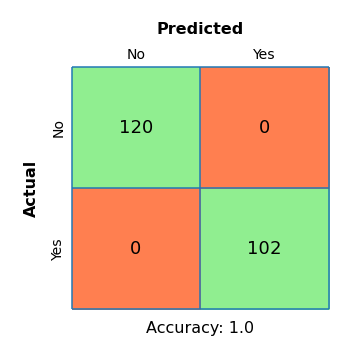

In [13]:
y_pred = tree.predict(X_test)
plot_confusion_matrix(y_train, tree.predict(X_train), labels = ['No', 'Yes'], metric = 'accuracy')

Since decision trees are so flexible, they will often perfectly predict the training data. Remember though, that what we care about is how well the model generalizes.

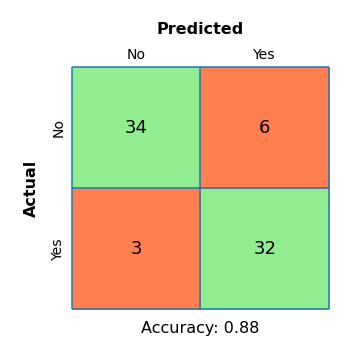

In [14]:
y_pred = tree.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')

In [15]:
roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])

0.8821428571428571

We do see a drop in model performance on the test data. This is a sign of overfitting.

To correct for this problem, we can take an ensemble approach, which means that we will build many decision trees on subsets of the features and data and then average the predictions of all of the trees. This will force our model to try and find more general patterns that will work on the test set.

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
forest = RandomForestClassifier(random_state = 321)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=321)

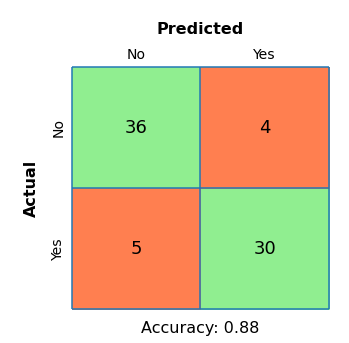

In [18]:
y_pred = forest.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')

In [19]:
roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])

0.9421428571428572

We see some improvement over using a single tree, but we could do better. Random forests have a lot of hyperparameters that can be tuned to improve out model. Here are a few of these parameters:

* **n_estimators:** Number of decision trees to train. Default is 10. More trees = less variance, but slower to train and predict
* **max_depth:** Maximum depth (number of splits). By default, there is no max depth.
* **min_samples_leaf:** Minimum number of samples per leaf. Setting this higher keeps the decision trees from paying too much attention to any single data point.

These parameters can be tuned to try to improve the model that you get, and there are ways to automatically tune these parameters. See, for example, sklearn's GridSearchCV or RandomSearchCV.

In [20]:
forest = RandomForestClassifier(n_estimators = 1000, max_depth = 5, min_samples_leaf = 5, random_state = 321)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=1000,
                       random_state=321)

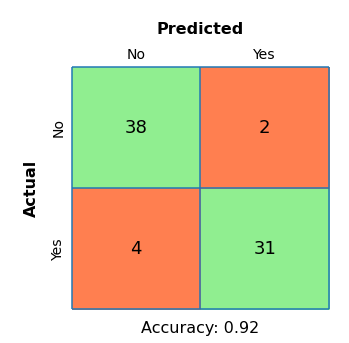

In [21]:
y_pred = forest.predict(X_test)
plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')

In [22]:
roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])

0.9592857142857143

A nice perk of using random forest models is that we can see which features are the most important in making predictions.

**Caution:** Feature importances tell which features the model is using, but not _how_ it is using those features.

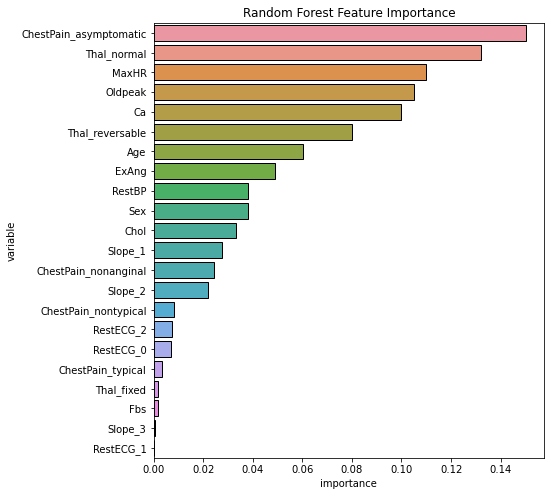

In [23]:
importances = pd.DataFrame({'variable': X.columns,
                           'importance': forest.feature_importances_}).sort_values('importance', ascending = False)


fig, ax = plt.subplots(figsize = (7,8))
sns.barplot(data = importances,
            x = 'importance', y = 'variable', ax = ax, edgecolor = 'black')
plt.title('Random Forest Feature Importance');

## Appendix: Regularized Regression

Now, let's try out a penalized regression model. 

We'll do a LASSO regression model, which penalizes in a way that tends to force some of the coefficients to be zero.

Since LASSO penalizes the coefficients, which depend on the magnitude of the varaibles, we should first scale our predictors so that they are on comparable scales.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler().fit(X_train)

In [ ]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
logreg = LogisticRegression(max_iter=10000,
                            penalty = 'l1',             # LASSO penalty
                            C = 0.05,                   # Lower C = stronger penalty
                           solver = 'saga')
logreg.fit(X_train_scaled, y_train)

In [ ]:
y_pred = logreg.predict(X_test_scaled)

plot_confusion_matrix(y_test, y_pred, labels = ['No', 'Yes'], metric = 'accuracy')

With this model, we get a slighty lower accuracy.

In [ ]:
roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:,1])

We also get a slightly lower ROC AUC.

In [ ]:
coefficients = pd.DataFrame({
    'variable': X.columns,
    'coefficient': logreg.coef_[0]
})

In [ ]:
coefficients[coefficients['coefficient'] != 0]

However, we end up with a much simpler model overall compared to the model above.